In [ ]:
#LSTM 実装
# sin波形をLSTMで予想する

ライブラリ

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("ggplot")
%matplotlib inline

教師データ

In [ ]:
x = np.linspace(0,499,500)
y = np.sin(x * 2 * np.pi / 50)

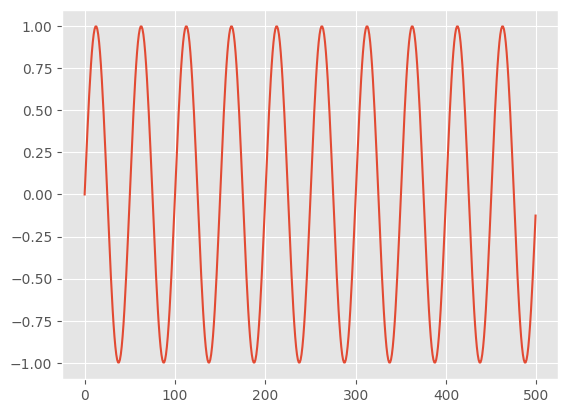

In [ ]:
plt.plot(x,y)

窓スライド処理

In [ ]:
def make_sequence_data(y, num_sequence):
  num_data = len(y)
  seq_data = [] # 4つ刻みのデータを格納する用のリスト
  target_data = [] # seq_dataの1つ次のデータを格納する用のリスト
  for i in range(num_data - num_sequence):
    seq_data.append(y[i : i + num_sequence])
    target_data.append(y[i+num_sequence : i + num_sequence + 1])
  seq_arr = np.array(seq_data)
  target_arr = np.array(target_data)
  return seq_arr, target_arr

In [ ]:
#周期性がどの程度あるのか？ここをよく見ながら設定すること！！
seq_length = 40

In [ ]:
y_seq, y_target = make_sequence_data(y , seq_length)

In [ ]:
y_seq.shape

(460, 40)

In [ ]:
# 今回は40刻み事なので500-40=460で　周期長が40となっている

In [ ]:
print(y_seq)

[[ 0.          0.12533323  0.24868989 ... -0.99802673 -0.99802673
  -0.98228725]
 [ 0.12533323  0.24868989  0.36812455 ... -0.99802673 -0.98228725
  -0.95105652]
 [ 0.24868989  0.36812455  0.48175367 ... -0.98228725 -0.95105652
  -0.90482705]
 ...
 [ 0.77051324  0.84432793  0.90482705 ... -0.68454711 -0.58778525
  -0.48175367]
 [ 0.84432793  0.90482705  0.95105652 ... -0.58778525 -0.48175367
  -0.36812455]
 [ 0.90482705  0.95105652  0.98228725 ... -0.48175367 -0.36812455
  -0.24868989]]


In [ ]:
y_target.shape

(460, 1)

テストデータ作成
最終10行をテストデータにする

In [ ]:
num_test = 10
y_seq_train = y_seq[:-num_test]
y_seq_test = y_seq[-num_test:]
y_target_train = y_target[:-num_test]
y_target_test = y_target[-num_test:]

In [ ]:
y_seq_train.shape

(450, 40)

pytorch用の処理

In [ ]:
# tensorに変換する
y_seq_t = torch.FloatTensor(y_seq_train)
y_target_t = torch.FloatTensor(y_target_train)

LSTMの定義
 #x_last=x[-1]は予測したラストを抽出

In [ ]:
class LSTM(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size = 1,hidden_size = self.hidden_size)
    self.linear = nn.Linear(self.hidden_size,1)

  def forward(self,x):
    x, _ =self.lstm(x)
    x_last = x[-1]
    x = self.linear(x_last)
    return x

In [ ]:
#hidden size =100　隠れ層数の設定
model = LSTM(100)

Loss関数と最適化アルゴの定義

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

LSTMに入力するための処理

In [ ]:
y_seq_t.size()

torch.Size([450, 40])

In [ ]:
# LSTMにインプットする際に先にシーケンス上の軸が来て、つぎにバッチサイズが来る、最後にインプットサイズの軸が来る
# y_seq_tの順番が逆であるので入れ替える必要がある

In [ ]:
y_seq_t = y_seq_t.permute(1,0)

In [ ]:
y_seq_t.size()

torch.Size([40, 450])

In [ ]:
y_target_t = y_target_t.permute(1,0)

In [ ]:
y_target_t.size()

torch.Size([1, 450])

In [ ]:
# 40×450の2次元テンサーなので、1次元にする必要がる
 # unsqueezeはsqueezeの反対なのでsqueezeは40x450x1を絞って40x450にするがunsqueezeは次元を広げる働きがある。dim=-1にすると最後の列に1を付与できる

In [ ]:
y_seq_t = y_seq_t.unsqueeze(dim=-1)
y_target_t = y_target_t.unsqueeze(dim=-1)

In [ ]:
y_seq_t.shape

torch.Size([40, 450, 1])

学習トレーニング
ミニバッチのランニングLossを初期化することが通常だが
今回はバッチ学習のためいきなりOptimizerの初期化を実施します

In [ ]:
num_epochs = 80
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(y_seq_t)
    loss = criterion(output, y_target_t)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    if epoch % 10 == 0:
        print("epoch: {}, loss: {}".format(epoch, loss.item()))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 450, 1])) that is different to the input size (torch.Size([450, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0, loss: 0.5037203431129456
epoch: 10, loss: 0.3857090473175049
epoch: 20, loss: 0.2358168065547943
epoch: 30, loss: 0.06967425346374512
epoch: 40, loss: 0.01021696999669075
epoch: 50, loss: 0.003337556030601263
epoch: 60, loss: 0.001225961372256279
epoch: 70, loss: 0.0008635655976831913


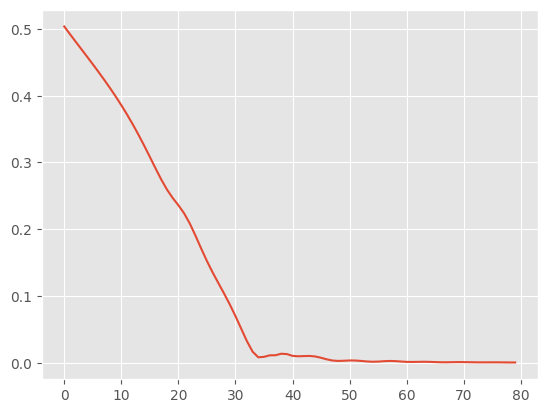

In [ ]:
plt.plot(losses)

In [ ]:
y_seq_test_t = torch.FloatTensor(y_seq_test)
y_seq_test_t = y_seq_test_t.permute(1,0)
y_seq_test_t = y_seq_test_t.unsqueeze(dim=-1)

In [ ]:
y_seq_test_t.size()

torch.Size([40, 10, 1])

In [ ]:
y_pred = model(y_seq_test_t)

In [ ]:
y_pred.size()

torch.Size([10, 1])

(450.0, 500.0)

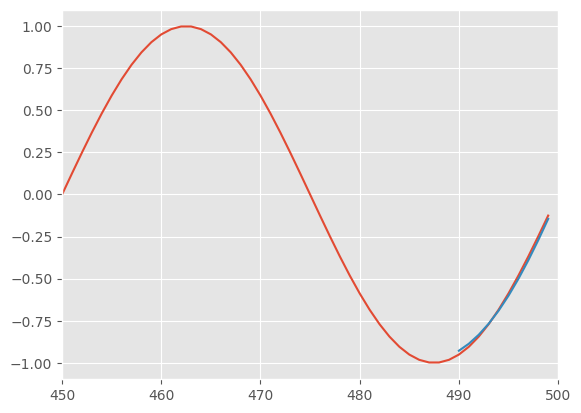

In [ ]:
plt.plot(x,y)
plt.plot(np.arange(490,500),y_pred.detach())
plt.xlim([450,500])